In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install CatBoost

In [3]:
!ls 'gdrive/My Drive/Sbermarket hacklab'

'404 found - Sbermarket.gslides'   sample_submission.csv
'404 old.gslides'		   Sbermarket_ipynb_.ipynb
 kaggle_tab_1345		  'Skoltech Hack (basket predict).gslides'
 merged_data.csv		   tab_2
 Merge.ipynb			   tab_6_city.csv
 my_file.ipynb			   tab_6_city.xlsx


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
merged = pd.read_csv('gdrive/My Drive/Sbermarket hacklab/merged_data.csv', index_col=None)
merged.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,order_id,user_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,order_created_time,retailer,platform,city_name,gender,bdate,age
0,0,139128,1050,97633689,236.89,1,0.0,5045454,3573,122,119,-1,-1,-1,-1,-1,-1,-1
1,1,139128,1050,97633791,178.16,1,0.0,73719,5154,122,119,-1,-1,-1,-1,-1,-1,-1
2,2,139128,1050,97635201,173.28,1,0.0,7000939,2846,85,84,-1,-1,-1,-1,-1,-1,-1
3,3,139128,1050,97635312,73.69,1,0.0,7386015,3342,85,84,-1,-1,-1,-1,-1,-1,-1
4,4,139128,1050,97635414,282.14,1,0.0,73291,2846,85,84,-1,-1,-1,-1,-1,-1,-1


In [6]:
merged['user_id'].nunique()

107068

In [7]:
merged['product_id'].nunique()

91994

In [8]:
merged = merged[merged['product_id'] != 0]
len(merged)

21466723

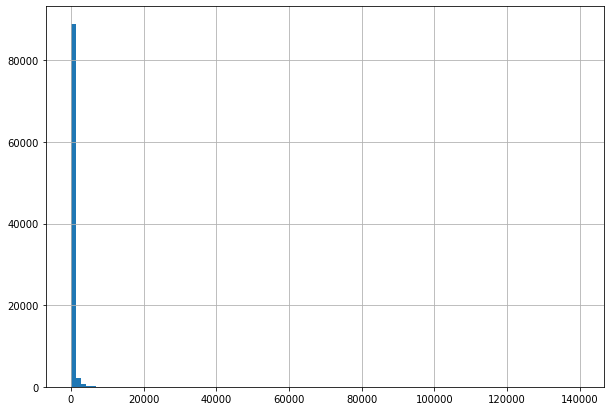

In [9]:
plt.figure(figsize=(10, 7))
merged['product_id'].value_counts().hist(bins=100)

In [10]:
merged['user_id'].nunique()

107066

In [11]:
merged['product_id'].value_counts().mean()

233.35170067287729

In [12]:
merged['product_id'].median()

72012.0

In [13]:
groupby_0 = pd.DataFrame({'count' : merged.groupby(['product_id']).size()}).reset_index()
groupby_0 = groupby_0.sort_values(['count'], ascending=False)
groupby_0

,product_id,count
193,709,139570
9290,39590,44804
71,166,36970
10588,55133,34424
361,1300,32142
...,...,...
76028,7054745,1
76025,7054739,1
35947,3860282,1
35948,3860283,1


In [14]:
groupby_0['count'].sum()

21466723

In [15]:
# доля покрытия
groupby_0[:1000]['count'].sum() / groupby_0['count'].sum()

0.28358841729126516

In [16]:
# доля покрытия
groupby_0[:3000]['count'].sum() / groupby_0['count'].sum()

0.4745225901503457

In [17]:
# доля покрытия
groupby_0[:35000]['count'].sum() / groupby_0['count'].sum()

0.9561352238066332

In [18]:
# фильтруем
top_products = groupby_0[:3000]['product_id'].tolist()

In [19]:
merged = merged[merged['product_id'].isin(top_products)]
len(merged)

10186445

In [20]:
merged['user_id'].nunique()

105801

In [21]:
users_n_orders = merged.groupby(['user_id'])['order_id'].nunique().to_frame('count').reset_index()
users_n_orders

,user_id,count
0,51,17
1,65,23
2,400,5
3,576,8
4,608,4
...,...,...
105796,3142760,1
105797,3142766,1
105798,3142774,1
105799,3142820,1


In [22]:
valid_users = users_n_orders[users_n_orders['count'] >= 2]
valid_users_ids = valid_users['user_id'].tolist()
len(valid_users_ids)

85793

In [23]:
merged = merged[merged['user_id'].isin(valid_users_ids)]
len(merged)

9968211

In [24]:
merged.dtypes

Unnamed: 0              int64
order_id                int64
user_id                 int64
line_item_id            int64
price                 float64
quantity                int64
discount              float64
product_id              int64
brand_name              int64
master_category_id      int64
parent_category_id      int64
order_created_time     object
retailer                int64
platform                int64
city_name               int64
gender                  int64
bdate                  object
age                     int64
dtype: object

In [25]:
merged_ = merged[merged['order_created_time'].values != -1]
merged_ = merged_[merged_['order_created_time'].values != '-1']

In [26]:
merged_.head(3)

,Unnamed: 0,order_id,user_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,order_created_time,retailer,platform,city_name,gender,bdate,age
282503,282503,5531326,691783,28336408,40.00,1,6.99,67693,700,577,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22
282504,282504,5531326,691783,28336410,139.00,1,106.00,1536,815,582,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22
282506,282506,5531326,691783,28336412,57.41,1,19.79,3817542,1355,91,90,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22


In [27]:
merged_ = merged_.drop(columns=['Unnamed: 0']) 
merged_['user_id'].nunique()

83358

In [28]:
# Change data types to reduce memory footprint
merged_ = merged_.astype({
    'user_id': 'int32',
    'order_id': 'int32',
    'price': 'float32',
    'quantity': 'int32',
    'discount': 'float32',
    'product_id': 'int32',
    'brand_name': 'int32',
    'master_category_id': 'int32',
    'parent_category_id': 'int32',
    'order_created_time': str,
    'retailer': 'int32',
    'platform': 'int32',
    'city_name': 'int32',
    'gender': 'int32',
    'age': 'int32'}, copy=False)

In [29]:
# merged_['order_created_time_'] = merged_['order_created_time'].merged_.strftime('%y-%m-%d')
# merged_.head(3)
# .dt.strftime('%Y-%m-%d')
# .apply(lambda x: x[:10])
merged_['order_created_time'] = pd.to_datetime(merged_['order_created_time'], format='%Y-%m-%d %H:%M:%S', exact=True)

In [30]:
merged_.dtypes

order_id                       int32
user_id                        int32
line_item_id                   int64
price                        float32
quantity                       int32
discount                     float32
product_id                     int32
brand_name                     int32
master_category_id             int32
parent_category_id             int32
order_created_time    datetime64[ns]
retailer                       int32
platform                       int32
city_name                      int32
gender                         int32
bdate                         object
age                            int32
dtype: object

In [31]:
merged_.head(3)

,order_id,user_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,order_created_time,retailer,platform,city_name,gender,bdate,age
282503,5531326,691783,28336408,40.00,1,6.990000,67693,700,577,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22
282504,5531326,691783,28336410,139.00,1,106.000000,1536,815,582,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22
282506,5531326,691783,28336412,57.41,1,19.790001,3817542,1355,91,90,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22


In [32]:
last_order = merged_.groupby(['user_id'])['order_created_time'].min().to_frame('order_created_time').reset_index()
last_order

,user_id,order_created_time
0,400,2020-06-13 13:26:03
1,576,2020-06-26 08:05:37
2,608,2020-08-04 16:30:07
3,766,2020-01-08 12:16:16
4,1012,2020-01-09 14:08:24
...,...,...
83353,3127156,2020-09-15 17:11:12
83354,3128356,2020-09-15 22:50:23
83355,3130099,2020-09-16 05:31:28
83356,3133198,2020-09-16 07:58:02


In [33]:
target = pd.merge(merged_, last_order, on=['user_id', 'order_created_time']) 
print(len(target))
target.head(3)

1113594


,order_id,user_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,order_created_time,retailer,platform,city_name,gender,bdate,age
0,5531326,691783,28336408,40.00,1,6.990000,67693,700,577,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22
1,5531326,691783,28336410,139.00,1,106.000000,1536,815,582,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22
2,5531326,691783,28336412,57.41,1,19.790001,3817542,1355,91,90,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22


In [34]:
target_user_product_pos = target[['user_id', 'product_id']]
target_user_product_pos['target'] = 1
target_user_product_pos.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,product_id,target
0,691783,67693,1
1,691783,1536,1
2,691783,3817542,1


In [35]:
merged_.head(3)

,order_id,user_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,order_created_time,retailer,platform,city_name,gender,bdate,age
282503,5531326,691783,28336408,40.00,1,6.990000,67693,700,577,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22
282504,5531326,691783,28336410,139.00,1,106.000000,1536,815,582,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22
282506,5531326,691783,28336412,57.41,1,19.790001,3817542,1355,91,90,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22


In [36]:
features = merged_.groupby(['user_id', 'product_id', 'master_category_id', 
                            'parent_category_id', 'retailer', 'gender', 'age'], as_index=False).agg(
  product_count=pd.NamedAgg(column='order_created_time', aggfunc='count'),
  avg_discount=pd.NamedAgg(column='discount', aggfunc='mean'),
  max_discount=pd.NamedAgg(column='discount', aggfunc='max'),
  min_discount=pd.NamedAgg(column='discount', aggfunc='min'),
  avg_price=pd.NamedAgg(column='price', aggfunc='mean'),
  max_price=pd.NamedAgg(column='price', aggfunc='max'),
  min_price=pd.NamedAgg(column='price', aggfunc='min'),
  max_date=pd.NamedAgg(column='order_created_time', aggfunc='max'))
            
features.head(3)

,user_id,product_id,master_category_id,parent_category_id,retailer,gender,age,product_count,avg_discount,max_discount,min_discount,avg_price,max_price,min_price,max_date
0,400,177,26,20,4,-1,-1,2,9.995,19.99,0.0,64.895004,74.889999,54.900002,2020-07-09 12:01:19
1,400,407,38,35,4,-1,-1,2,51.000,51.00,51.0,99.000000,99.000000,99.000000,2020-06-13 16:30:57
2,400,487,38,35,4,-1,-1,1,64.000,64.00,64.0,125.000000,125.000000,125.000000,2020-06-19 11:57:25


In [37]:
train = pd.merge(features, target_user_product_pos, on=['user_id', 'product_id'], how='left')
train.head(3)

,user_id,product_id,master_category_id,parent_category_id,retailer,gender,age,product_count,avg_discount,max_discount,min_discount,avg_price,max_price,min_price,max_date,target
0,400,177,26,20,4,-1,-1,2,9.995,19.99,0.0,64.895004,74.889999,54.900002,2020-07-09 12:01:19,1.0
1,400,407,38,35,4,-1,-1,2,51.000,51.00,51.0,99.000000,99.000000,99.000000,2020-06-13 16:30:57,1.0
2,400,487,38,35,4,-1,-1,1,64.000,64.00,64.0,125.000000,125.000000,125.000000,2020-06-19 11:57:25,NaN


In [38]:
train['target'] = train['target'].fillna(0)
print(train['target'] .value_counts())
print(train['target'] .value_counts(normalize=True))

0.0    5210008
1.0    1186301
Name: target, dtype: int64
0.0    0.814534
1.0    0.185466
Name: target, dtype: float64


In [39]:
len(train) == len(features)

False

In [40]:
len(features)

6372271

In [41]:
features[['user_id', 'product_id']].groupby('user_id').product_id.nunique().sum()

6086960

### Модель


In [56]:
train['GroupId'] = train['user_id'].apply(str)
len(set(train['GroupId']))

83358

In [43]:
train_labels = train['target']
train = train.drop(columns=['target'])

In [82]:
from catboost import CatBoost, CatBoostClassifier, Pool

In [104]:
%%time
param = {
    'iterations': 100, 
    'task_type': 'GPU', 
    'loss_function': 'YetiRank',
}
model = CatBoost(param)
train_size = int(len(train) * 0.5)
test_size = int(len(train) * 0.5)
train_pool = Pool(
    data=train.iloc[:train_size], 
    label=train_labels.iloc[:train_size], 
    group_id=train.iloc[:train_size]['GroupId'],
)
test_pool = Pool(
    data=train.iloc[train_size: train_size + test_size], 
    label=train_labels.iloc[train_size: train_size + test_size], 
    group_id=train.iloc[train_size: train_size + test_size]['GroupId'],
)
model.fit(train_pool, verbose=0, plot=True)
print(model.feature_importances_)
print(model.best_score_, model.best_iteration_)

from sklearn.metrics import roc_auc_score

predictions = model.predict(train_pool)
print('train auc', roc_auc_score(train_pool.get_label(), predictions))

predictions = model.predict(test_pool)
print('test auc', roc_auc_score(test_pool.get_label(), predictions))

CatBoostError: ignored